# A.G.N

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 98% !important; }</style>"))

## Full Synchrotron Spectra

In [2]:
#Import Package Modules to Code
import numpy
import numpy as np
import math as m
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad, dblquad
import scipy.special as sp
import scipy.constants as cn
import numpy
import numpy as np
import math as m
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import quad, dblquad
import scipy.constants as cn
import scipy.special as sp
import astropy.units as u
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.utils.plot import plot_sed
import time

kpc = 3.085677558128*10**21
pc = 3.085677558128*10**18

#Constants in cgs
fortio =4.80*10**(-10)
c = 2.997925*10**10
me =9.109*10**(-28)
mp = 1.672614*10**(-24)
hpl = 6.25*10**(-27)

#Free Parameters of Models
B=0.001 #s.f.p
gmin_e = 1.2*10**5
gmax_e = 10**6
gmin_p = 3*10**4
gmax_p = 3*10**5
ps_e = 4.4
ps_p = 2
No_e=6.5*10**50 #f.p
No_p=1.5*10**56

Ro=50*pc #source radius
d_L= 18.5*10**3*kpc#(source distance):1.00e+27 cm

#We separate the constant parts in our calculation for easier coding
C_e=No_e*(-ps_e+1)/((me*c**2)**(-ps_e+1)*(gmax_e**(-ps_e+1)-gmin_e**(-ps_e+1)))
C_p=No_p*(-ps_p+1)/((mp*c**2)**(-ps_p+1)*(gmax_p**(-ps_p+1)-gmin_p**(-ps_p+1)))
Constant_e=(C_e*4*cn.pi*fortio**2*me*c*(me*c**2)**(-ps_e))/3
Constant_p=(C_p*4*cn.pi*fortio**2*mp*c*(mp*c**2)**(-ps_p))/3

#Electrons power [erg/s]
def p_e(n):
    res = dblquad(lambda x, g: Constant_e*n*g**(-2-ps_e)*(9+36*x**2+16*x**4)/((3+4*x**2)
        *m.sqrt(1+(x**2)/3))*np.exp(-n*4*cn.pi*me*c*(1+(4*x**2)/3)*m.sqrt(1+x**2/3)
        /(g**2*3*fortio*B)), gmin_e, gmax_e, lambda x: 0, lambda x: np.inf)
    return res

v_e = numpy.logspace(8,17,100)
P_e = v_e*0

for i in range(len(v_e)):
    P_e[i] = p_e(v_e[i])[0]  
       
        
#Proton power [erg/s]
def p_p(n):
    res = dblquad(lambda x, g: Constant_p*n*g**(-2-ps_p)*(9+36*x**2+16*x**4)/((3+4*x**2)*
        m.sqrt(1+(x**2)/3))*np.exp(-n*4*cn.pi*mp*c*(1+(4*x**2)/3)*m.sqrt(1+x**2/3)
        /(g**2*3*fortio*B)), gmin_p, gmax_p, lambda x: 0, lambda x: np.inf)
    return res

v_p = numpy.logspace(8,17,100)
P_p = v_p*0

for i in range(len(v_p)):
    P_p[i] = p_p(v_p[i])[0]  
       
#Calculation of synchrotron self-absorption component for electrons
        
Ca_e=No_e*(-ps_e+1)/(4*cn.pi*Ro**3*(me*c**2)**(-ps_e+1)*(gmax_e**(-ps_e+1)-gmin_e**(-ps_e+1)))
AbsConstant_e=Ca_e*(ps_e+2)*fortio**2*(me*c**2)**(-ps_e)*c/(6)

def abs_e(n):      
    resa = dblquad(lambda x, g: AbsConstant_e*(g**(-ps_e-3)/n)*(9+36*x**2+16*x**4)
         /((3+4*x**2)*m.sqrt(1+(x**2)/3))*np.exp(-n*4*cn.pi*me*c*(1+(4*x**2)/3)
         *m.sqrt(1+x**2/3)/(g**2*3*fortio*B)), gmin_e, gmax_e
         , lambda x: 0, lambda x: np.inf, epsabs=1.49e-28, epsrel=1.49e-18)
    return resa

Abs_e = v_e*0
Pabs_e = v_e*0

ssa_e = 0

for i in range(len(v_e)):
    Abs_e[i] = abs_e(v_e[i])[0] 
    
    
Iabs_e=v_e*0


t_ne = Ro*Abs_e #optiko vathos
   
#find the index of the table t_n in which the source is becoming optical thick    
for i in range(len(v_e)):      
    if t_ne[i] >= 1:
        ssa_e = i
        
vssa_e = v_e[ssa_e] #aprrox is the value of vssa


#Iabs2_e = P_e*(1-np.exp(-Abs_e*Ro))/((4*cn.pi)**2*Ro**3*Abs_e) 
Iabs_e = P_e*(-np.expm1(-Abs_e*Ro))/((4*cn.pi)**2*Ro**3*Abs_e)

        
#From Intensity to Flux 
Fabs_e=v_e*0

for i in range(len(v_e)):
    Fabs_e[i]=cn.pi*Ro**2*Iabs_e[i]/d_L**2 
    
#Calculation of synchrotron self-absorption component for protons
    
Ca_p=No_p*(-ps_p+1)/(4*cn.pi*Ro**3*(mp*c**2)**(-ps_p+1)*(gmax_p**(-ps_p+1)-gmin_p**(-ps_p+1)))
AbsConstant_p=Ca_p*(ps_p+2)*fortio**2*(mp*c**2)**(-ps_p)*c/(6)

def abs_p(n):      
    res = dblquad(lambda x, g: AbsConstant_p*(g**(-ps_p-3)/n)*(9+36*x**2+16*x**4)/((3+4*x**2)
        *m.sqrt(1+(x**2)/3))*np.exp(-n*4*cn.pi*mp*c*(1+(4*x**2)/3)*m.sqrt(1+x**2/3)/(g**2*3*fortio*B))
        , gmin_p, gmax_p, lambda x: 0, lambda x: np.inf, epsabs=1.49e-28, epsrel=1.49e-18)
    return res

Abs_p = v_p*0
Pabs_p = v_p*0

ssa_p = 0

for i in range(len(v_p)):
    Abs_p[i] = abs_p(v_p[i])[0]
    
Iabs_p=v_p*0


t_np = Ro*Abs_p #optiko vathos
   
#find the index of the table t_n in which the source is becoming optical thick    
for i in range(len(v_p)):      
    if t_np[i] >= 1:
        ssa_p = i
        
vssa_p = v_p[ssa_p] #aprrox is the value of vssa


#Iabs2_e = P_e*(1-np.exp(-Abs_e*Ro))/((4*cn.pi)**2*Ro**3*Abs_e) 
Iabs_p = P_p*(-np.expm1(-Abs_p*Ro))/((4*cn.pi)**2*Ro**3*Abs_p)

        
#From Intensity to Flux 
Fabs_p=v_p*0

for i in range(len(v_p)):
    Fabs_p[i]=cn.pi*Ro**2*Iabs_p[i]/d_L**2    
    
    
#insert data
logdv = np.array([9.177536,9.686636,9.927370,10.988960,11.372912,14.522444,14.800029,14.950365,15.123852])
lognFn = -np.array([15.84841,15.36888,15.29448,14.99820,15.14997,13.30146,13.51873,13.61827,13.73002])
elognFn = -np.array([15.80702,15.32749,15.25309,14.95681,15.10857,13.15534,13.34264,13.55827,13.69430])
ElognFn = -np.array([15.89417,15.41464,15.34024,15.04396,15.19572,13.52331,13.81976,13.68791,13.76894])
#-----------------------------------------------------------------------------------------------------
dv=10**logdv
nFn=10**lognFn
enFn=10**elognFn
EnFn=10**ElognFn

err=nFn-enFn
Err=EnFn-nFn

asymmetric_error = [err,Err]

Fall = Fabs_e+Fabs_p
#insert data
logdv = np.array([9.177536,9.686636,9.927370,10.988960,11.372912,14.522444,14.800029,14.950365,15.123852])
lognFn = -np.array([15.84841,15.36888,15.29448,14.99820,15.14997,13.30146,13.51873,13.61827,13.73002])
elognFn = -np.array([15.80702,15.32749,15.25309,14.95681,15.10857,13.15534,13.34264,13.55827,13.69430])
ElognFn = -np.array([15.89417,15.41464,15.34024,15.04396,15.19572,13.52331,13.81976,13.68791,13.76894])
#-----------------------------------------------------------------------------------------------------
dv=10**logdv
nFn=10**lognFn
enFn=10**elognFn
EnFn=10**ElognFn

err=nFn-enFn
Err=EnFn-nFn

asymmetric_error = [err,Err]


Fabsc_p = np.nan_to_num(Fabs_p)


for i in range(len(v_p)):
    Fall[i]=Fabs_e[i] + Fabsc_p[i]
    
 

C:\Users\CHARAL~1\AppData\Local\Temp/ipykernel_2260/2210023393.py:160: RuntimeWarning: invalid value encountered in true_divide
  Iabs_p = P_p*(-np.expm1(-Abs_p*Ro))/((4*cn.pi)**2*Ro**3*Abs_p)


In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

Text(0.5, 1.0, 'Synchrotron Spectra for power law distribution')

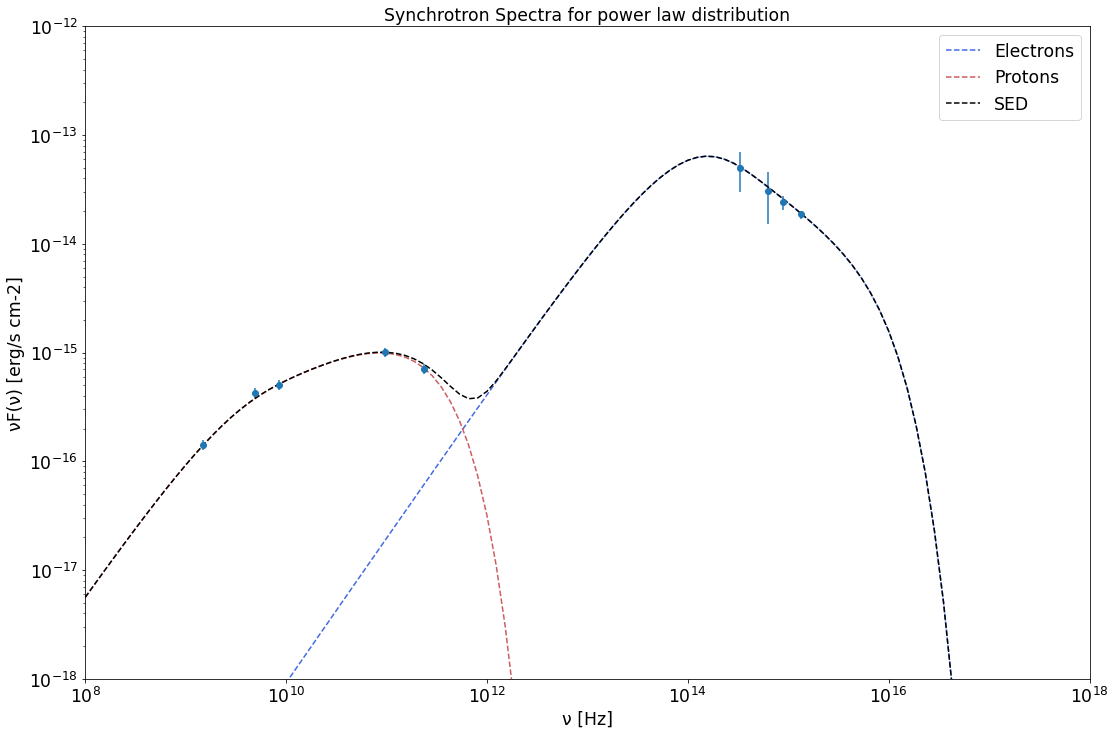

In [4]:
plt.figure(figsize=(18,12))    

plt.plot(v_e,v_e*Fabs_e , label='Electrons',ls="--", color="royalblue")
plt.plot(v_p,v_p*Fabs_p, label='Protons',ls="--", color="indianred")
plt.plot(v_p,v_p*Fall, label='SED',ls="--", color="black")


plt.legend()
plt.errorbar(x=dv, y=nFn, yerr=asymmetric_error, fmt='o')

plt.ylim(1e-18,1e-12)
plt.xlim(1e8,1e18)
plt.xlabel("ν [Hz]")
plt.ylabel("νF(ν) [erg/s cm-2]")
plt.yscale("log")
plt.xscale("log")
#plt.scatter(dv,nFn)
plt.title("Synchrotron Spectra for power law distribution")    
    


In [5]:
4*cn.pi*d_L**2*10**(-13)

4.0950047013392706e+39

In [6]:
U_b = 4*cn.pi*Ro**3*B**2/(8*cn.pi)

In [7]:
U_elv = quad(lambda g: AbsConstant_e*4*cn.pi*me*c**2*(g*me*c**2)**(-ps_e+1) , gmin_e, gmax_e)

In [8]:
U_el = 4*cn.pi*Ro**3*U_elv[0]

In [9]:
U_prv = quad(lambda g: AbsConstant_p*4*cn.pi*mp*c**2*(g*mp*c**2)**(-ps_p+1) , gmin_p, gmax_p)

In [10]:
U_pr = 4*cn.pi*Ro**3*U_prv[0]

In [11]:
Utot = U_b+U_el+U_pr

In [12]:
Utot

5.0461210435077334e+69

In [13]:
U_pr

4.431699264161678e+56

In [14]:
U_b

1.8362492996004463e+54

In [15]:
U_el

5.046121043507289e+69

In [16]:
vFabs_e = v_e*Fabs_e
vFabs_p = v_p*Fabsc_p

In [17]:
max_value = numpy.amax(vFabs_e)

In [18]:
for i in range(len(v_e)):
        if vFabs_e[i] == max_value:
            fmax = i
        
        
vmax = v_e[fmax] #aprrox is the value of vssa


In [19]:
max_value


6.397701692710762e-14

In [20]:
vmax

151991108295293.3

In [21]:
max_value = numpy.max(vFabs_p)

for i in range(len(v_p)):
        if vFabs_p[i] == max_value:
            fmax = i
        
        
vmax = v_p[fmax] #aprrox is the value of vssa


In [22]:
max_value


9.916587565190016e-16

In [23]:
vmax

81113083078.96889

In [24]:
4*cn.pi*d_L**2*9.916587565190016e-16

4.0608472700695667e+37

In [25]:
g_peak = (4*cn.pi*mp*c*vmax/(3*fortio*B))**(1/2)

In [26]:
g_peak

188398.47635470759

In [27]:
tcool = 4.8*10**18*B**(-2)*g_peak**(-1)

In [28]:
tcool

2.547791305362147e+19

In [29]:
tcool_e = tcool*(1836)**(-4)

In [30]:
tcool_e

2242193.7813680666